In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model

Using TensorFlow backend.


In [2]:
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

In [3]:
import numpy as np
import matplotlib as plt
import keras.backend as K
import tensorflow as tf

In [4]:
m = 50
n_z = 2
n_epoch = 10

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

In [7]:
X_train = X_train.reshape((-1, 28*28))
X_test = X_test.reshape((-1, 28*28))

Encoder

In [8]:
x_input = Input(shape=(28*28,), name='encoder_input')
hidden = Dense(512, activation='relu', name='hidden1')(x_input)
z_mean = Dense(n_z, name='z_mean')(hidden) # mean
z_log_var = Dense(n_z, name='z_log_var')(hidden) # log(sigma^2) 

Random sample from bottleneck layer

In [9]:
def sample_z(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.shape(z_mean)[1]
    eps = K.random_normal(shape=(batch_size, latent_dim), 
                         mean=0, stddev=1)
    sample = z_mean + K.exp(z_log_var / 2) * eps
    
    return sample

In [10]:
z = Lambda(sample_z)([z_mean, z_log_var])

In [11]:
encoder = Model(x_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        hidden1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        hidden1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [12]:
latent_inputs = Input(shape=(2,), name='z_sampling')
hidden2 = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(28*28, activation='sigmoid')(hidden2)

In [13]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [57]:
outputs = decoder(encoder(x_input)[2])

In [58]:
vae = Model(x_input, outputs, name='vae')

In [59]:
from keras.objectives import binary_crossentropy
from keras.optimizers import Adam

In [60]:
xent_loss = binary_crossentropy(x_input, outputs) * 784
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
loss = K.mean(xent_loss + kl_loss)

In [61]:
vae.add_loss(loss)

In [62]:
vae.compile(optimizer=Adam(1e-5))

In [63]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [64]:
vae.fit(X_train,
        shuffle=True,
        epochs=50,
        batch_size=256,
        validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 22us/step - loss: 222.5874 - val_loss: 220.6926
Epoch 2/50
60000/60000 [==============================] - 1s 15us/step - loss: 219.7248 - val_loss: 218.9012
Epoch 3/50
60000/60000 [==============================] - 1s 15us/step - loss: 217.3906 - val_loss: 215.9316
Epoch 4/50
60000/60000 [==============================] - 1s 15us/step - loss: 215.1726 - val_loss: 213.4876
Epoch 5/50
60000/60000 [==============================] - 1s 15us/step - loss: 212.3436 - val_loss: 210.7000
Epoch 6/50
60000/60000 [==============================] - 1s 15us/step - loss: 209.5420 - val_loss: 208.1125
Epoch 7/50
60000/60000 [==============================] - 1s 16us/step - loss: 206.4177 - val_loss: 204.7471
Epoch 8/50
60000/60000 [==============================] - 1s 16us/step - loss: 202.9476 - val_loss: 200.5526
Epoch 9/50
60000/60000 [==============================] - 1s 16us/step - loss:

In [74]:
vae.compile(optimizer=Adam(1e-6))

In [75]:
vae.fit(X_train,
        shuffle=True,
        epochs=50,
        batch_size=256,
        validation_data=(X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 23us/step - loss: 152.1883 - val_loss: 153.4623
Epoch 2/50
60000/60000 [==============================] - 1s 15us/step - loss: 152.1616 - val_loss: 153.4443
Epoch 3/50
60000/60000 [==============================] - 1s 15us/step - loss: 152.1716 - val_loss: 153.4116
Epoch 4/50
60000/60000 [==============================] - 1s 15us/step - loss: 152.1416 - val_loss: 153.3843
Epoch 5/50
60000/60000 [==============================] - 1s 15us/step - loss: 152.1606 - val_loss: 153.4128
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 152.1212 - val_loss: 153.4358
Epoch 7/50
60000/60000 [==============================] - 1s 15us/step - loss: 152.1137 - val_loss: 153.4061
Epoch 8/50
60000/60000 [==============================] - 1s 17us/step - loss: 152.1393 - val_loss: 153.4035
Epoch 9/50
60000/60000 [==============================] - 1s 16us/step - loss:

In [76]:
import matplotlib.pyplot as plt

In [79]:
n = 30  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

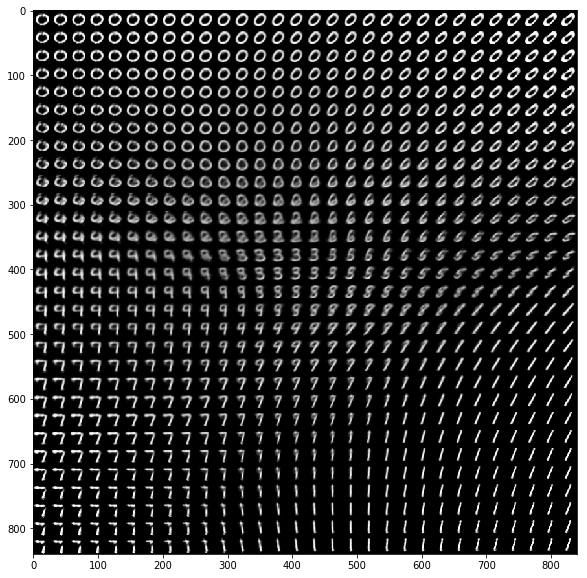

In [81]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()